In [957]:
from collections import namedtuple
import glob
from itertools import product
import json
import logging
import math
import os
import random

import soundfile as sf
from pyrubberband import pyrb
import argparse
import librosa.effects
import librosa.core
import librosa.output
import numpy as np
import pydub
import tensorflow as tf
tf.enable_v2_behavior()

from tqdm.notebook import trange, tqdm

from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [958]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

In [959]:
sr=16000

In [960]:
def load_data(p_files):    
    
    p_samples = load_audio_from_files(p_files, "wav", 3000, 8000)
    p_specs = audio2spec(p_samples, 160, 80, 640)
    p_labels = np.ones(len(p_samples))
    
    return p_samples, p_specs, p_labels

In [23]:
# n_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/libri_3s/dev-clean/*/*/*.wav')[:5]
# p_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/alexa_8khz/*/*.wav')[::10]

In [961]:
n_files = glob.glob('/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-100/*/*/*.flac')
p_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/alexa/*/*.wav')[::10]

In [143]:
len(n_files)

28539

In [264]:
samples_bg, _ = sf.read(n_files[0])

Text(0.5, 1.0, 'Source Other Speech')

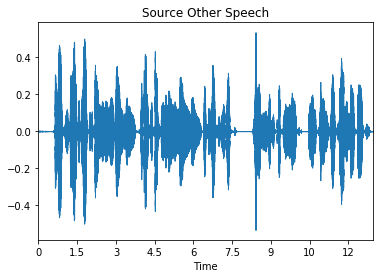

In [265]:
librosa.display.waveplot(samples_bg, sr=sr)
plt.title('Source Other Speech')

In [266]:
ipd.Audio(samples_bg, rate=sr)

In [267]:
# split into sentences
audio_chunks = librosa.effects.split(samples_bg, top_db=60, frame_length=320, hop_length=160)
chunk_lens = [(chunk[1] - chunk[0]) / float(sr) for chunk in audio_chunks]
sentence_chunks = [chunk for chunk in audio_chunks if ((chunk[1] - chunk[0]) / float(sr)) > 0.5]
len(sentence_chunks)

4

In [106]:
def get_chunk(samples, chunk):
    return np.array(samples[chunk[0]:chunk[1]])

Text(0.5, 1.0, 'Source Other Speech')

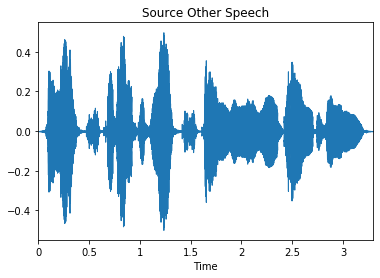

In [269]:
sentence = get_chunk(samples_bg, sentence_chunks[0])
librosa.display.waveplot(sentence, sr=sr)
plt.title('Source Other Speech')

In [467]:
samples, _ = sf.read(p_files[0])
samples_trimmed, index = librosa.effects.trim(samples, top_db=30)

Text(0.5, 1.0, 'Source Wakeword')

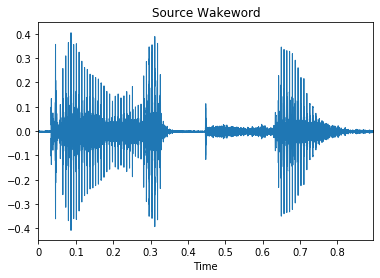

In [468]:
librosa.display.waveplot(samples_trimmed, sr=sr)
plt.title('Source Wakeword')

In [272]:
ipd.Audio(samples_trimmed, rate=sr)

In [273]:
specs = audio2spec(np.expand_dims(samples_trimmed, 0) , sr // 50, sr // 100, sr // 50)

100%|██████████| 1/1 [00:00<00:00, 222.21it/s]


Text(0.5, 1.0, 'Source Wakeword')

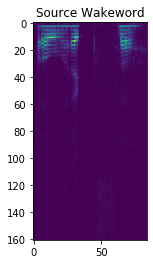

In [274]:
plt.figure()
plt.imshow(specs[0])
plt.title('Source Wakeword')

In [275]:
samples_timealtered = pyrb.time_stretch(samples, sr=sr, rate=1.5)
samples_timealtered_, _ = librosa.effects.trim(samples_timealtered, top_db=20)
ipd.Audio(samples_timealtered_, rate=sr)

100%|██████████| 1/1 [00:00<00:00, 199.47it/s]


Text(0.5, 1.0, 'Time Altered Wakeword')

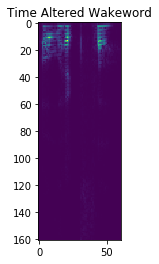

In [276]:
specs = audio2spec(np.expand_dims(samples_timealtered_, 0) , sr // 50, sr // 100, sr // 50)
plt.figure()
plt.imshow(specs[0])
plt.title('Time Altered Wakeword')

In [277]:
samples_pitchaltered = pyrb.pitch_shift(samples_timealtered, sr=sr, n_steps=-2.5)
samples_pitchaltered_, _ = librosa.effects.trim(samples_pitchaltered, top_db=20)
ipd.Audio(samples_pitchaltered_, rate=sr)

100%|██████████| 1/1 [00:00<00:00, 267.24it/s]


Text(0.5, 1.0, 'Time and Pitch Altered Wakeword')

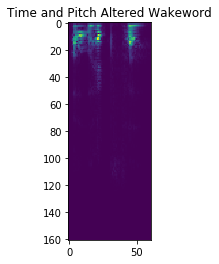

In [278]:
specs = audio2spec(np.expand_dims(samples_pitchaltered_, 0) , sr // 50, sr // 100, sr // 50)
plt.figure()
plt.imshow(specs[0])
plt.title('Time and Pitch Altered Wakeword')

In [962]:
def mix_two(a_,b, b_advance=0):
    a = np.copy(a_)
    if len(b) <= b_advance:
        a[-b_advance:(len(b)-b_advance)] += b
        return a
    else:
        if b_advance > 0:
            a[-b_advance:] += b[:b_advance]
            return np.concatenate([a, b[b_advance:]], axis=0)
        else:
            return np.concatenate([a, b], axis=0)
    

def mix_three(a, b, c, b_advance=320, c_advance=320, output_advance=0, output_len=32000):
    """
     b_advance
          <---
         ^ default output start is whenever B starts
    |---A-----|---B---|----C-----|
                   <--
             c_advance^
    output_advance advances the default output start.
    """
    ab = mix_two(a,b,b_advance)
    abc = mix_two(ab,c,c_advance)
    s = max(len(a)-b_advance - output_advance, 0)
    e = s + output_len
    out = np.zeros(output_len)
    actual_len = len(abc)-s
    out[:actual_len] = abc[s:e]
    return out


In [280]:
mixed = mix_three(get_chunk(samples_bg, sentence_chunks[0]), np.array(samples_pitchaltered_), get_chunk(samples_bg, sentence_chunks[1]), b_advance=20*sr//50, c_advance=15*sr//50, output_advance=30*sr//50)
ipd.Audio(mixed, rate=sr)

In [963]:
time_stretch_opts = np.arange(0.8,1.25,.05).tolist()
pitch_shift_opts = np.arange(-3,3.5,0.5).tolist()
b_advance_opts = np.arange(0, sr//2, sr//20, dtype=int).tolist()
c_advance_opts = np.arange(0, sr//4, sr//20, dtype=int).tolist()
output_advance_opts = np.arange(sr//10, sr, sr//10, dtype=int).tolist()
loudness_opts = [0.25,0.5,1.0]
augment_opts = list(product(*[time_stretch_opts, pitch_shift_opts, b_advance_opts, c_advance_opts, output_advance_opts, loudness_opts]))

In [964]:
def augment_audio(p_file, n_file, time_stretch, pitch_shifts, b_advance, c_advance, output_advance, loudness):
    sr = 16000
    output_len = 32000
    samples_bg, _ = sf.read(n_file)
    # split into sentences
    audio_chunks = librosa.effects.split(samples_bg, top_db=60, frame_length=320, hop_length=160)
    chunk_lens = [(chunk[1] - chunk[0]) / float(sr) for chunk in audio_chunks]
    sentence_chunks = [chunk for chunk in audio_chunks if ((chunk[1] - chunk[0]) / float(sr)) > 1.0]
    def get_chunk(samples, chunk):
        return np.array(samples[chunk[0]:chunk[1]])
    if len(sentence_chunks) < 2:
        sentence_chunks = [[len(samples_bg)//2, len(samples_bg)-1],[0,len(samples_bg)//2]]
    leading_chunk, trailing_chunk = random.sample(sentence_chunks, 2)
    leading = get_chunk(samples_bg, leading_chunk)
    trailing = get_chunk(samples_bg, trailing_chunk)
        
    wakeword, _ = sf.read(p_file)
    wakeword_timealtered = pyrb.time_stretch(wakeword, sr=sr, rate=time_stretch)
    wakeword_pitchaltered = pyrb.pitch_shift(wakeword_timealtered, sr=sr, n_steps=pitch_shifts)
    wakeword_pitchaltered_, _ = librosa.effects.trim(wakeword_pitchaltered, top_db=30)
    k = np.sqrt((trailing**2).sum() / len(trailing)) / np.sqrt((wakeword_pitchaltered_**2).sum() / len(wakeword_pitchaltered_))
    wakeword_pitchaltered_ *= k*loudness
    return mix_three(leading, np.array(wakeword_pitchaltered_), trailing, b_advance=b_advance, c_advance=c_advance, output_advance=output_advance, output_len=output_len)
    

In [965]:
args = augment_opts[random.randint(0,len(augment_opts)-1)]
print(args)

(0.9500000000000002, 3.0, 0, 1600, 9600, 0.5)


In [966]:
pi = random.randint(0,len(p_files)-1)
ni = random.randint(0,len(n_files)-1)
mixed = augment_audio(p_files[pi], n_files[ni], *args)
ipd.Audio(mixed, rate=sr)

In [504]:
mixed_as_ints = (mixed * 2**15).astype(np.int16)
audio_segment = pydub.AudioSegment(
    mixed_as_ints.tobytes(), 
    frame_rate=sr,
    sample_width=mixed_as_ints.dtype.itemsize, 
    channels=1
)

In [506]:
audio_segment.export('/scratch0/ilya/locDownloads/six.wav', format='wav')
# librosa.output.write_wav('/scratch0/ilya/locDownloads/five.wav', mixed, sr)

<_io.BufferedRandom name='/scratch0/ilya/locDownloads/six.wav'>

## Negative augment example

In [172]:
def mix_two_negatives(n_file1, n_file2, b_advance, output_advance, loudness):
    sr = 16000
    output_len = 32000
    a, _ = sf.read(n_file1)
    b, _ = sf.read(n_file2)
    
    a, _ = librosa.effects.trim(a, top_db=40)
    b, _ = librosa.effects.trim(b, top_db=40)
    leading_chunk, trailing_chunk = [[len(a)//2, len(a)-1],[0,len(b)//2]]
    leading = get_chunk(a, leading_chunk)
    trailing = get_chunk(b, trailing_chunk)

    k = np.sqrt((leading**2).sum() / len(leading)) / np.sqrt((trailing**2).sum() / len(trailing))
    trailing *= k*loudness
    mixed = mix_two(leading, trailing, b_advance=b_advance)
    
    s = max(len(leading)-b_advance - output_advance, 0)
    e = s + output_len
    out = np.zeros(output_len)
    actual_len = len(mixed)-s
    out[:actual_len] = mixed[s:e]
    return out

In [101]:
b_advance_opts = np.arange(0, sr//2, sr//20, dtype=int).tolist()
output_advance_opts = np.arange(sr//10, sr, sr//10, dtype=int).tolist()
loudness_opts = [0.25,0.5,1.0,1.25, 1.5]
negative_augment_opts = list(product(*[b_advance_opts, output_advance_opts, loudness_opts]))

In [184]:
args = negative_augment_opts[random.randint(0,len(negative_augment_opts)-1)]
print(args)

(4800, 14400, 1.0)


In [185]:
ni0 = random.randint(0,len(n_files)-1)

ni = random.randint(0,len(n_files)-1)
print(n_files[ni0], n_files[ni])

/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-100/8051/118101/8051-118101-0014.flac /scratch1/ilya/locDoc/data/LibriSpeech/train-clean-100/8238/283452/8238-283452-0044.flac


In [186]:
mixed = mix_two_negatives(n_files[ni0], n_files[ni], *args)
ipd.Audio(mixed, rate=sr)

## Loading audio and spectrogram from tfrecord dataset

In [1]:
tfrecord_file = '/scratch0/ilya/locDoc/data/alexa/v2/train/_positive_00_0000.tfrecord'
# tfrecord_file = '/scratch0/ilya/locDoc/data/alexa/v2/train/_negative_00_0000.tfrecord'

In [ ]:
examples = []
specs = []
limit = 100
for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)
    
    spec_shape = eg_np.features.feature["spectrogram_shape"].int64_list.value
    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec = np.array(spec).reshape(spec_shape)
    specs.append(spec)
    if i > limit:
        break

In [289]:
i = random.randint(0,limit-1)

In [290]:
ipd.Audio(examples[i], rate=16000)

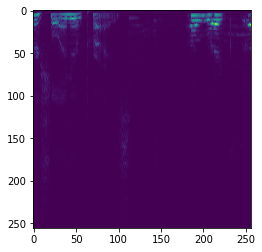

In [291]:
plt.figure()

# y = np.array(examples[26]).astype(float) / 2**15
# spec = np.abs(librosa.core.stft(y, win_length=closest_power_of_2(sr // 50), hop_length=closest_power_of_2(sr // 100), n_fft=2*closest_power_of_2(sr // 50)))
# plt.imshow(spec)

plt.imshow(specs[i])

In [969]:
y = mixed[8000:24000]
ipd.Audio(y, rate=sr)

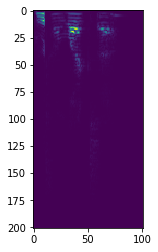

In [982]:
spec = np.abs(librosa.core.stft(y, win_length=(sr // 40), hop_length=(sr // 100), n_fft=(sr // 40)))
plt.imshow(spec)

In [983]:
spec.shape

(201, 101)

In [979]:
closest_power_of_2(sr // 40)

512

## Label start/end times of keywords

In [985]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [353]:
def chunk_duration_s(chunk, sr=16000):
    return (chunk[1]-chunk[0]) / float(sr)

In [992]:
def source_file_to_start_sample(source_file):
    sound = pydub.AudioSegment.from_file(source_file, format="wav")
    sound_hi = pydub.effects.high_pass_filter(sound, 85)
    sound_mid = pydub.effects.low_pass_filter(sound_hi, 255)
    y = np.array(sound_mid.get_array_of_samples(), dtype=np.float64) / 2**15

    audio_chunks = []
    silence_db = 60
    while silence_db > 0 and (len(audio_chunks) < 1 or np.array([chunk_duration_s(c) for c in audio_chunks]).max() > 0.8 or np.array([chunk_duration_s(c) for c in audio_chunks]).max() < 0.25):
        silence_db -= 5
        audio_chunks = librosa.effects.split(y, top_db=silence_db, frame_length=sr // 40, hop_length=sr // 100)

    if len(audio_chunks) == 0:
        return 0
#     print(silence_db)
    chunk_lens = [chunk_duration_s(c) for c in audio_chunks]
    longest_chunk_i = chunk_lens.index(max(chunk_lens))
    return audio_chunks[longest_chunk_i]

### Interactive start/end time labelling

In [ ]:
source_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/alexa/*/*.wav')

In [1865]:
metadata = {}

In [1866]:
# load source files
with open('data/alexa.annotated.ryan_todo.json') as json_file:
    metadata_todo = json.load(json_file)
source_files = list(metadata_todo.keys())
source_files = [os.path.join('/scratch0/ilya/locDoc/data/alexa/v1/alexa', fname) for fname in source_files]

In [1870]:
# Init
ci = -1

In [1871]:
# Next
ci += 1
user_start = None
user_end = None

0
Segment is 760ms long


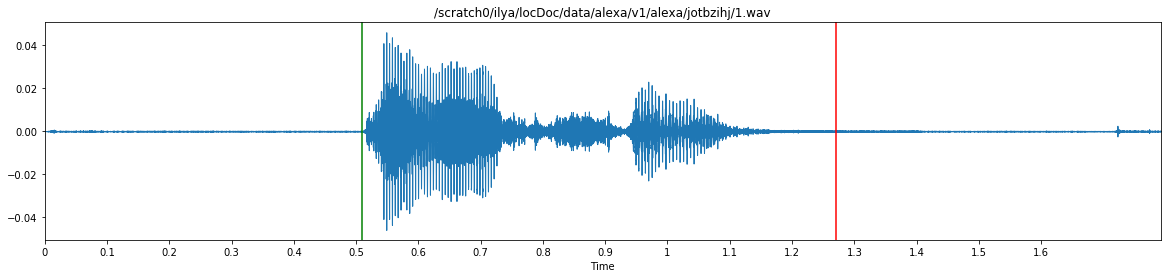

In [1872]:
# Test
print(ci)
fig = plt.figure()
y, sr = sf.read(source_files[ci])
try:
    guess_start, guess_end = source_file_to_start_sample(source_files[ci])
except:
    guess_start, guess_end = [0, len(y)]
selected_start = user_start if user_start is not None else guess_start
selected_end = user_end if user_end is not None else guess_end
librosa.display.waveplot(y, sr=sr)
plt.title(source_files[ci])
plt.axvline(x=selected_start/float(sr), c='green')
plt.axvline(x=selected_end/float(sr), c='red')
plt.xticks(np.array(list(range(int(len(y)/float(sr)*10)))) / 10.0)
fig.set_figwidth(20)
print('Segment is %ims long' % int((selected_end-selected_start)/float(sr)*1000) )
# fig
ipd.Audio(y[selected_start:selected_end], rate=sr)

In [1826]:
# Edit (Optional)
user_start = int(0.55 * sr)

In [1837]:
# Edit (Optional)
user_end = int(0.9 * sr)

In [1873]:
# Save in memory
file_id = os.path.join(*source_files[ci].split('/')[-2:])
print(file_id, selected_start, selected_end)
metadata[file_id] = [int(selected_start), int(selected_end)]
len(metadata)

jotbzihj/1.wav 8160 20320


1

In [1874]:
# Write memory to file
with open('data/alexa.annotated.xxx.json', 'w') as metafile:
    json.dump(metadata, metafile)